# Assignment 2: Data Cleaning - Part 2: Imputation
## Group 105
- Natasa Bolic (300241734)
- Brent Palmer (300193610)
## Imports

In [32]:
# Imports
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score
from sklearn.impute import KNNImputer

## Introduction

Paragraph here

## Dataset Description

**Url:** https://www.kaggle.com/datasets/uciml/autompg-dataset <br>
**Name:** Auto-mpg Dataset <br>
**Author:** UCI Machine Learning Repository (originally from StatLib library, maintained at Carnegie Mellon University) <br>
**Purpose:** The dataset includes the technical specifications of cars. The original purpose of collection is not explicitly listed on Kaggle, but it appears to have been collected to evaluate how fuel consumption relates to various other attributes of vehicles (e.g., horsepower, weight). In 1993, Ross Quinlan used the dataset to train a machine learning model to predict fuel consumption based on the other eight features.<br>
**Shape:** There are 398 rows and 9 columns. (398, 9)<br>
**Features:** Further explanation of the features retrieved from https://code.datasciencedojo.com/tshrivas/dojoHub/tree/master/Auto%20MPG%20Data%20Set
- `mpg` (numerical): The vehicle's fuel efficiency, measured in miles per gallon (mpg).
- `cylinders` (categorical): The number of cylinders in the vehicle's engine.
- `displacement` (numerical): The total volume of the cylinders in the vehicle, measured in cubic inches.
- `horsepower` (numerical): A measurement of the vehicle's engine's power.
- `weight` (numerical): The weight of the vehicle, measured in pounds (lbs).
- `acceleration` (numerical): Time to go from 0 to 60 miles per hour, measured in seconds.
- `model year` (categorical): The year of release of the vehicle.
- `origin` (categorical): The region of manufacturing.
    - 1: USA
    - 2: Europe
    - 3: Japan
- `car name` (categorical): The name of the vehicle.

**Missing Values:** Yes, there are missing values. In particular, horsepower has 6 missing values.

## Loading Dataset and Basic Exploration

In [2]:
# Read in the dataset from a public repository
url = "https://raw.githubusercontent.com/Natasa127/CSI4142-A2/refs/heads/main/auto-mpg.csv"
auto_df = pd.read_csv(url)
auto_df.head()

,mpg,cylinders,displacement,horsepower,weight,acceleration,model year,origin,car name
0,18.0,8,307.0,130,3504,12.0,70,1,chevrolet chevelle malibu
1,15.0,8,350.0,165,3693,11.5,70,1,buick skylark 320
2,18.0,8,318.0,150,3436,11.0,70,1,plymouth satellite
3,16.0,8,304.0,150,3433,12.0,70,1,amc rebel sst
4,17.0,8,302.0,140,3449,10.5,70,1,ford torino


In [3]:
auto_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 398 entries, 0 to 397
Data columns (total 9 columns):
 #   Column        Non-Null Count  Dtype  
---  ------        --------------  -----  
 0   mpg           398 non-null    float64
 1   cylinders     398 non-null    int64  
 2   displacement  398 non-null    float64
 3   horsepower    398 non-null    object 
 4   weight        398 non-null    int64  
 5   acceleration  398 non-null    float64
 6   model year    398 non-null    int64  
 7   origin        398 non-null    int64  
 8   car name      398 non-null    object 
dtypes: float64(3), int64(4), object(2)
memory usage: 28.1+ KB


In [4]:
auto_df.shape

(398, 9)

### Basic Cleaning
Since there are only six missing values in the entire dataset (1.5% of the rows), we decided to use the listwise removal approach to delete these rows. The assignment requires simulating missing values (as indicated by part b), which enables us to do cross-validation since we know the true values of the data. Thus, deleting these six rows in advance will make the cross-validation approach possible. Since it is such a small amount of data, this deletion will not significantly impact our analysis.

**References:** <br>
Listwise removal: https://saturncloud.io/blog/how-to-remove-rows-with-specific-values-in-pandas-dataframe/ <br>
Series equality: https://pandas.pydata.org/docs/reference/api/pandas.Series.eq.html

In [5]:
auto_df = auto_df.drop(auto_df[auto_df['horsepower'] == '?'].index)

In [6]:
auto_df['horsepower'].eq('?').sum()

0

The six rows have successfully been removed, and we are now ready for imputation and evaluation using cross-validation with simulation.

## Imputation Tests

### Imputation Test 1: Random Sample Imputation of Missing Acceleration Values (Univariate)

#### (a) Chosen Attribute

We have chosen to test random sample imputation (univariate) on the acceleration attribute.

#### (b) Simulate Missing Values

We are simulating missing acceleration values using the MCAR approach, where the missing acceleration values are chosen completely at random regardless of their own value or the values of the other attributes.

We are simulating the missing values in a copy of the original DataFrame such that we can evaluate the imputation accuracy afterwards by comparing the imputed acceleration values with the true acceleration values.

**References:** <br>
MCAR: https://www.kaggle.com/code/yassirarezki/handling-missing-data-mcar-mar-and-mnar-part-i <br>
Loc Documentation: https://pandas.pydata.org/docs/reference/api/pandas.DataFrame.loc.html <br>
Copy Documentation: https://pandas.pydata.org/docs/reference/api/pandas.DataFrame.copy.html <br>
Fixing Random Seed: https://stackoverflow.com/questions/21494489/what-does-numpy-random-seed0-do

In [7]:
# Create a copy of the DataFrame
missing_acceleration_df = auto_df.copy()

# Set the random seed to make the results reproducible (comment this out to try on truly random missing values)
np.random.seed(0)

# Generate a series that holds True for rows that will be missing, and False for rows that will persist
missing_percent = 0.1
missing_values = np.random.choice([True, False], len(auto_df), p=[missing_percent, 1 - missing_percent])

# Replace the acceleration with NaN where the missing_values series is True
missing_acceleration_df.loc[missing_values, "acceleration"] = np.nan

# Check to see if values are missing
missing_acceleration_df['acceleration'].isna().sum()

39

#### (c) Program an Imputation Approach to Replace the Missing Values

We have chosen random sample imputation as our first imputation approach. Random sample imputation is a univariate technique.

**References:** <br>
Sample Documentation: https://pandas.pydata.org/docs/reference/api/pandas.DataFrame.sample.html

In [8]:
# Save a series of the non-missing acceleration values
acceleration_values = missing_acceleration_df.loc[missing_acceleration_df['acceleration'].notna(), 'acceleration']

# Sample a number of non-missing acceleration values with replacement equal to the number of missing values
# Note that random state is set to one to make the results reproducible. This can be removed for truly random samples
sampled_acceleration_values = acceleration_values.sample(missing_acceleration_df['acceleration'].isna().sum(), replace=True, random_state=1).values

# Replace the missing values with sampled acceleration values
missing_acceleration_df.loc[missing_values, "acceleration"] = sampled_acceleration_values

# Check to see if values are missing
missing_acceleration_df['acceleration'].isna().sum()

0

#### (d) Evaluate to What Extent Your Approach is Finding the Missing Values

Since we are using the cross-validation with simulation approach where we simulate missing data, we can compare our imputed values to the true values.

##### Evaluation Using MSE

We will first use the Mean Squared Error (MSE) approach, where we take the average of the squared difference of each imputed value with the respective true value.

**References:** <br>
Mean Squared Error: https://scikit-learn.org/stable/modules/generated/sklearn.metrics.mean_squared_error.html

In [9]:
# First determine the original values of the missing data
original_values = auto_df.loc[missing_values, 'acceleration'].values

# Then determine the imputed values of the missing data
random_sampling_imputed_values = missing_acceleration_df.loc[missing_values, 'acceleration'].values

# Compute MSE
mse = mean_squared_error(original_values, random_sampling_imputed_values)
mse

9.729999999999997

Thus, the mean squared error is 9.73 using random sample imputation. The MSE is not particularly intuitive to interpret as a standalone value since it is measured in squared units. A great way to interpret MSE is to compare it to the MSE of a baseline method, like median imputation. In the following cell we will perform median imputation, and compare the MSE values to evaluate the effectiveness of the random sampling method.

In [10]:
# Replace the imputed values with NaN where the missing_values series is True.
missing_acceleration_df.loc[missing_values, "acceleration"] = np.nan

# Save the median of the non-missing acceleration values
acceleration_median = missing_acceleration_df.loc[missing_acceleration_df['acceleration'].notna(), 'acceleration'].median()

# Replace the missing values with median
missing_acceleration_df.loc[missing_values, "acceleration"] = acceleration_median

# Compute MSE
original_values = auto_df.loc[missing_values, 'acceleration'].values
median_imputed_values = missing_acceleration_df.loc[missing_values, 'acceleration'].values
median_mse = mean_squared_error(original_values, median_imputed_values)
median_mse

5.330512820512821

Given that random sampling gave an MSE of 9.73 and default value imputation using the median gave an MSE of 5.33, the random sampling approach is not very good comparatively in this case. 

##### Evaluation Using MAE

A second approach to evaluation is Mean Absolute Error (MAE), which is more intuitive since the units of MAE are the same as the original data. MAE takes the average absolute difference between each imputed value with the respective true value.

**References:** <br>
Mean Squared Error: https://scikit-learn.org/stable/modules/generated/sklearn.metrics.mean_absolute_error.html

In [11]:
mae = mean_absolute_error(original_values, random_sampling_imputed_values)
mae

2.6128205128205124

The MAE is 2.61, which means that on average, the imputed acceleration had an error of 2.61 seconds. Given our domain knowledge, a value of 2.61 seconds is not very large of an error for acceleration.

##### Evaluation Using R-Squared

A third approach to evaluation is R-Squared, which computes the variance in the line with the original data.

**References:** <br>
R-Squared: https://scikit-learn.org/stable/modules/generated/sklearn.metrics.r2_score.html

In [12]:
r2 = r2_score(original_values, random_sampling_imputed_values)
r2

-1.0689971899509283

Explanation of r2_score

##### Evaluation Conclusion
Despite the random sampling MSE being notably worse than the default value imputation using the median MSE, random sampling is still usable as seen through the reasonable MAE score of 2.61 seconds. 

### Imputation Test 2: Correlational Imputation of Missing Weight Values Using Displacement (Bivariate)

#### (a) Chosen Attribute

We have chosen to test correlational imputation (bivariate) on the weight attribute, where weight is the attribute with missing values that is being imputed.

However, when using correlational imputation, we need to select an attribute that is correlated with weight to base the imputation on. To determine the best attribute to select, we generate a correlation matrix to identify the feature that is most strongly correlated with weight.

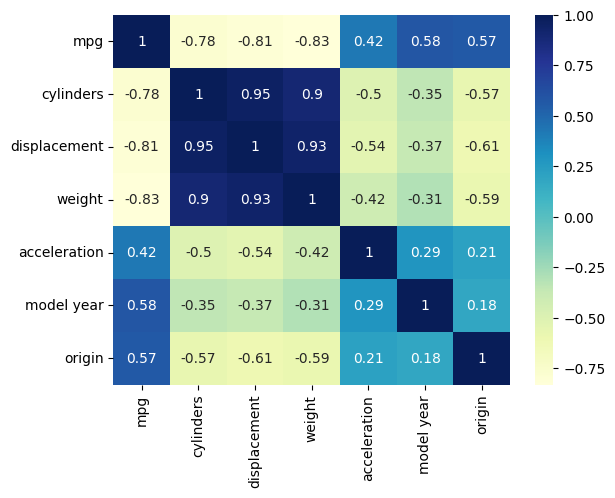

In [13]:
# Plot correlation heatmap
correlation_heatmap = sns.heatmap(auto_df.corr(numeric_only=True), cmap="YlGnBu", annot=True)

# Displaying heatmap
plt.show()

Since weight is highly correlated with displacement, we will use displacement as the correlated attribute that our imputation is based on.

**References:** <br>
Correlation Heatmap: https://www.geeksforgeeks.org/how-to-create-a-seaborn-correlation-heatmap-in-python/

#### (b) Simulate Missing Values

We are simulating missing weight values using the MAR approach, where the missing weight values are chosen based on their relation to other observed variables, but not the weight value itself.

Specifically, we decided that the chance the weight is missing is related to the country of origin.
- American cars will have a 5% chance of a missing weight
- European cars will have a 10% chance of a missing weight
- Japanese cars will have a 20% chance of a missing weight

We are simulating the missing values in a copy of the original DataFrame such that we can evaluate the imputation accuracy afterwards by comparing the imputed weight values with the true weight values.

**References:** <br>
Apply: https://pandas.pydata.org/docs/reference/api/pandas.DataFrame.apply.html <br>
Random: https://www.w3schools.com/python/numpy/numpy_random.asp

In [14]:
# Create a copy of the DataFrame
missing_weight_df = auto_df.copy()

# Set the random seed to make the results reproducible (comment this out to try on truly random missing values)
np.random.seed(0)

# Create a function to return the probability that a weight is missing based on the origin
def weight_missing_probability(origin):
    # 5% chance an American car has a missing weight
    if origin == 1:
        return 0.05
    # 10% chance a European car has a missing weight
    elif origin == 2:
        return 0.1
    # 20% chance a Japanese car has a missing weight
    return 0.2

# Use the function above to create a vector representing the probability that each car's weight is missing
missing_probabilities = missing_weight_df['origin'].apply(weight_missing_probability)

# Create a boolean vector that represents which weights will be missing based on the missing probabilities and a vector of randomly generated values between 0 and 1
missing_values = np.random.rand(len(missing_probabilities)) < missing_probabilities

# Replace the weight with NaN where the missing_values vector is True
missing_weight_df.loc[missing_values, "weight"] = np.nan

# Check to see if values are missing
missing_weight_df["weight"].isna().sum()

33

#### (c) Program an Imputation Approach to Replace the Missing Values

We have chosen correlational imputation as our second imputation approach. Correlational imputation is a bivariate technique.

**References:** <br>
Linear Correlation Formula: https://uottawa.brightspace.com/d2l/le/content/490358/viewContent/6647323/View (Slide 44) <br>
Pearson Correlation: https://pandas.pydata.org/docs/reference/api/pandas.Series.corr.html#pandas.Series.corr <br>
Lambda in Apply: https://www.geeksforgeeks.org/applying-lambda-functions-to-pandas-dataframe/

In [15]:
# Calculate inputs to the linear correlation imputation formula
pearson_correlation = missing_weight_df['weight'].corr(missing_weight_df['displacement'])
weight_mean_y = missing_weight_df['weight'].mean()
weight_std_y = missing_weight_df['weight'].std()
displacement_mean_x = missing_weight_df['displacement'].mean()
displacement_std_x = missing_weight_df['displacement'].std()

# Function that computes the missing value based on the correlation between the missing attribute and a predictor attribute
def linear_correlation(X, pearson_correlation, mean_y, std_y, mean_x, std_x):
    return pearson_correlation * (std_y/std_x) * (X - mean_x) + mean_y

# Applies the linear correlation function to each missing weight, taking the corresponding displacement as input, alongside other necessary inputs calculated above
missing_weight_df.loc[missing_values, "weight"] = missing_weight_df.loc[missing_values, "displacement"].apply(
    lambda displacement: linear_correlation(displacement, pearson_correlation, weight_mean_y, weight_std_y, displacement_mean_x, displacement_std_x)
)

# Check to see if values are missing
missing_weight_df["weight"].isna().sum()

0

#### (d) Evaluate to What Extent Your Approach is Finding the Missing Values

Since we are using the cross-validation with simulation approach where we simulate missing data, we can compare our imputed values to the true values.

##### Evaluation Using MSE

We will first use the Mean Squared Error (MSE) approach, where we take the average of the squared difference of each imputed value with the respective true value.

In [16]:
# First determine the original values of the missing data
original_values = auto_df.loc[missing_values, 'weight'].values

# Then determine the imputed values of the missing data
correlational_imputed_values = missing_weight_df.loc[missing_values, 'weight'].values

# Compute MSE
mse = mean_squared_error(original_values, correlational_imputed_values)
mse

80874.72411653938

Thus, the mean squared error is 80875 using correlational imputation. The large number is alarming, but bear in mind that MSE is not particularly intuitive to interpret as a standalone value since it is measured in squared units. A great way to interpret MSE is to compare it to the MSE of a baseline method, like median imputation. In the following cell we will perform median imputation, and compare the MSE values to evaluate the effectiveness of the correlational imputation method.

In [17]:
# Replace the imputed values with NaN where the missing_values series is True.
missing_weight_df.loc[missing_values, "weight"] = np.nan

# Save the median of the non-missing weight values
weight_median = missing_weight_df.loc[missing_weight_df['weight'].notna(), 'weight'].median()

# Replace the missing values with median
missing_weight_df.loc[missing_values, "weight"] = weight_median

# Compute MSE
original_values = auto_df.loc[missing_values, 'weight'].values
median_imputed_values = missing_weight_df.loc[missing_values, 'weight'].values
median_mse = mean_squared_error(original_values, median_imputed_values)
median_mse

388843.0303030303

Given that correlational imputation gave an MSE of 80875 and default value imputation using the median gave an MSE of 388843, the correlational imputation approach is extremely effective; the MSE of the default value imputation is 4.8x larger, a notable difference.

##### Evaluation Using MAE

A second approach to evaluation is Mean Absolute Error (MAE), which is more intuitive since the units of MAE are the same as the original data. MAE takes the average absolute difference between each imputed value with the respective true value.

In [18]:
mae = mean_absolute_error(original_values, correlational_imputed_values)
mae

215.34079050612416

The MAE is 215, which means that on average, the imputed weight had an error of 215 pounds. Given our domain knowledge, a value of 215 pounds is not very large of an error for weight.

##### Evaluation Using R-Squared

A third approach to evaluation is R-Squared, which computes the variance in the line with the original data. 

In [19]:
r2 = r2_score(original_values, correlational_imputed_values)
r2

0.7124952944787646

Explanation of r2_score

##### Evaluation Conclusion
Correlational imputation scored a much better MSE than the default value imputation using the median MSE (median imputation MSE was 4.8x larger), so it is an improvement over the default. The MAE score of 215 pounds is very reasonable, given how large and varied the weights of vehicles are. Finally, the R-squared score of 0.72 PLACEHOLDER EXPLANATION. Overall, the correlational imputation was very successful at imputing missing weight values.

### Imputation Test 3: Similarity-based Imputation of Missing MPG Values (Multivariate)

#### (a) Chosen Attribute

We have chosen to test similarity-based imputation (multivariate) on the mpg (miles per gallon) attribute.

#### (b) Simulate Missing Values

We are simulating missing mpg values using the MNAR approach, where the missing mpg values are chosen based on their relation to their own value, and not just their relation to other observed variables.

Specifically, we decided that the chance the mpg is missing is related to the following thresholds:
- Cars with mpg <= 20 will have a 20% chance of a missing mpg value
- Cars with 20 < mpg <= 30 will have a 10% chance of a missing mpg value
- Cars with mpg > 30 will have a 5% chance of a missing mpg value

We have made it more likely that a cars with a poor mileage are missing data, since hypothetically, the manufacturers would not want to disclose poor fuel efficiency. We made cars with good mileage less likely to be missing data, since manufactureres would take pride in the value and be more likely to report it.

We are simulating the missing values in a copy of the original DataFrame such that we can evaluate the imputation accuracy afterwards by comparing the imputed weight values with the true weight values.

In [60]:
# Create a copy of the DataFrame
missing_mpg_df = auto_df.copy()

# Set the random seed to make the results reproducible (comment this out to try on truly random missing values)
np.random.seed(0)

# Create a function to return the probability that an mpg value is missing based on the mpg value
def mpg_missing_probability(mpg):
    # Cars with mpg <= 20 will have a 20% chance of a missing mpg value
    if mpg <= 20:
        return 0.2
    # Cars with 20 < mpg <= 30 will have a 10% chance of a missing mpg value
    elif mpg <= 30:
        return 0.1
    # Cars with mpg > 30 will have a 5% chance of a missing mpg value
    return 0.05

# Use the function above to create a vector representing the probability that each car's mpg value is missing
missing_probabilities = missing_mpg_df['mpg'].apply(mpg_missing_probability)

# Create a boolean vector that represents which weights will be missing based on the missing probabilities and a vector of randomly generated values between 0 and 1
missing_values = np.random.rand(len(missing_probabilities)) < missing_probabilities

# Replace the mpg with NaN where the missing_values vector is True
missing_mpg_df.loc[missing_values, "mpg"] = np.nan

# Check to see if values are missing
missing_mpg_df["mpg"].isna().sum()

51

#### (c) Program an Imputation Approach to Replace the Missing Values

We have chosen similarity-based imputation as our third imputation approach. Specifically, we are using KNN imputation as our implementation of similarity-based imputation. Similarity-based imputation is a multivariate technique.

**References:** <br>
Select Data Types: https://pandas.pydata.org/docs/reference/api/pandas.DataFrame.select_dtypes.html <br>
KNN Imputer: https://www.geeksforgeeks.org/handling-missing-data-with-knn-imputer/ <br>
Array to DF: https://www.geeksforgeeks.org/convert-a-numpy-array-to-pandas-dataframe-with-headers/

In [61]:
# Initialize KNN Imputer
imputer = KNNImputer(n_neighbors=2, weights="uniform")

# Select only the numeric columns
numeric_columns = missing_mpg_df.select_dtypes(include='number').columns

# Impute missing values
imputed_mpg_array = imputer.fit_transform(missing_mpg_df[numeric_columns])

# Convert returned array to DataFrame
imputed_mpg_df = pd.DataFrame(imputed_mpg_array, columns=numeric_columns, index=missing_mpg_df.index)

# Update the original DataFrame with new values
missing_mpg_df["mpg"] = imputed_mpg_df["mpg"]

# Check to see if values are missing
missing_mpg_df["mpg"].isna().sum()

0

#### (d) Evaluate to What Extent Your Approach is Finding the Missing Values

Since we are using the cross-validation with simulation approach where we simulate missing data, we can compare our imputed values to the true values.

##### Evaluation Using MSE

We will first use the Mean Squared Error (MSE) approach, where we take the average of the squared difference of each imputed value with the respective true value.

In [62]:
# First determine the original values of the missing data
original_values = auto_df.loc[missing_values, 'mpg'].values

# Then determine the imputed values of the missing data
similarity_based_imputed_values = missing_mpg_df.loc[missing_values, 'mpg'].values

# Compute MSE
mse = mean_squared_error(original_values, similarity_based_imputed_values)
mse

13.644411764705882

Thus, the mean squared error is 13.6 using similarity-based imputation. Note that the MSE is not particularly intuitive to interpret as a standalone value since it is measured in square units. A great way to interpret MSE is to compare it to the MSE of a baseline method, like median imputation. In the following cell we will perform median imputation, and compare the MSE values to evaluate the effectiveness of the similarity-based imputation method.

In [65]:
# Replace the imputed values with NaN where the missing_values series is True
missing_mpg_df.loc[missing_values, "mpg"] = np.nan

# Save the median of the non-missing mpg values
mpg_median = missing_mpg_df.loc[missing_mpg_df["mpg"].notna(), "mpg"].median()

# Replace the missing values with the median
missing_mpg_df.loc[missing_values, "mpg"] = mpg_median

# Compute MSE
original_values = auto_df.loc[missing_values, "mpg"].values
median_imputed_values = missing_mpg_df.loc[missing_values, "mpg"].values
median_mse = mean_squared_error(original_values, median_imputed_values)
median_mse

49.42392156862745

Given that similarity-based imputation gave an MSE of 13.6 and default value imputation using the median gave an MSE of 49.4, the correlational imputation approach is extremely effective; the MSE of the default value imputation is 3.6x larger, a notable difference.

##### Evaluation Using MAE

A second approach to evaluation is Mean Absolute Error (MAE), which is more intuitive since the units of MAE are the same as the original data. MAE takes the average absolute difference between each imputed value with the respective true value.

In [66]:
mae = mean_absolute_error(original_values, similarity_based_imputed_values)
mae

2.731372549019608

The MAE is 2.73, which means that on average, the imputed mpg had an error of 2.73 miles per gallon. Given our domain knowledge, an error of 2.73 miles per gallon is not a very large error for MPG.

##### Evaluation Using R-Squared

A third approach to evaluation is R-Squared, which computes the variance in the line with the original data. 

In [68]:
r2 = r2_score(original_values, similarity_based_imputed_values)
r2

0.654422105150612

Explanation of r2_score

##### Evaluation Conclusion

Similarity-based imputation using KNN scored a much better MSE than the default value imputation using the median MSE (median imputation MSE was 3.6x larger), so it is an improvement over the default. The MAE score of 2.73 pounds is very reasonable, given the magnitude the mpg of vehicles are. Finally, the R-squared score of 0.65 PLACEHOLDER EXPLANATION. Overall, the similarity-based imputation using KNN was very successful at imputing missing mpg values.